In [1]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(0)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))

        out = self.fc(out)
        # out = self.sigmoid(out)
        # predicted_class = torch.where(out > 0.5, torch.tensor(0.0), torch.tensor(1.0))
        return out
        # return predicted_class

input_size = 2
hidden_size = 32
num_layers = 10
output_size = 1

model = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)


In [40]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

data_dir = '../data/emg_rms_multi/'

class CustomDataset(Dataset):
    def __init__(self, file_list):
        self.file_list = file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = os.path.join(data_dir, self.file_list[idx])
        df = pd.read_csv(file_path)

        features = df[['V1', 'V2']].values
        label = df[df.columns[-1]].loc[0]

        return torch.FloatTensor(features), label


In [ ]:
file_list = os.listdir(data_dir)

train_files, val_files = train_test_split(file_list, test_size=0.2, random_state=42)

train_dataset = CustomDataset(train_files)
val_dataset = CustomDataset(val_files)

batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs[0], labels)
        print(loss)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        total_correct = 0
        total_samples = 0

        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs[0], labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        average_val_loss = val_loss / len(val_loader)
        accuracy = total_correct / total_samples

        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {average_val_loss:.4f}, Accuracy: {accuracy:.4f}')

In [46]:
import numpy as np

data_dir = '../data/emg_rms_multi/'
transformed_dfs = []

def calculate_wave_shape(x):
    x = np.array(x, dtype=np.float32)
    differences = np.abs(x[1:] - x[:-1])

    wave_shape = differences.sum()

    return wave_shape

def calculate_mean_signal_energy(x):
    x = np.array(x)
    sum_squared_values = np.sum(x**2)

    mean_signal_energy = sum_squared_values / len(x)

    return mean_signal_energy


for filename in os.listdir(data_dir):
    file_path = os.path.join(data_dir, filename)

    df = pd.read_csv(file_path)

    mae_v1 = df['V1'].abs().mean()
    ws_v1 = calculate_wave_shape(df['V1'])
    sen_v1 = calculate_mean_signal_energy(df['V1'])

    mae_v2 = df['V2'].abs().mean()
    ws_v2 = calculate_wave_shape(df['V2'])
    sen_v2 = calculate_mean_signal_energy(df['V2'])

    label = df[df.columns[-1]].iloc[0]

    features = {
        'MAE_V1': mae_v1,
        'WS_V1': ws_v1,
        'SEN_V1': sen_v1,
        'MAE_V2': mae_v2,
        'WS_V2': ws_v2,
        'SEN_V2': sen_v2,
        'Label': label
    }

    transformed_df = pd.DataFrame([features])

    transformed_dfs.append(transformed_df)

final_df = pd.concat(transformed_dfs, ignore_index=True)

# print(final_df)

In [61]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

features_columns = ['MAE_V1', 'WS_V1', 'SEN_V1', 'MAE_V2', 'WS_V2', 'SEN_V2']
label_column = 'Label'

features = final_df[features_columns].values
labels = final_df[label_column].values

features_tensor = torch.FloatTensor(features)
labels_tensor = torch.FloatTensor(labels)

dataset = TensorDataset(features_tensor, labels_tensor)

train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = train_test_split(dataset,test_size=0.3, train_size=0.7)
print(len(dataset))
# from torch.utils.data import WeightedRandomSampler

# sampler = WeightedRandomSampler([0.5, 0.5], 2, replacement=True)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
input_size = len(features_columns)
hidden_size = 20
num_layers = 9
output_size = 1
model = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(len(train_loader))
num_epochs = 90
threshold = 0.9
loss_val = []
loss_train = []
acc_val = []
for epoch in range(num_epochs):
    model.train()

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs).view(-1, 1)

        labels = labels.view(-1, 1)

        loss = criterion(outputs, labels)
        loss_train.append(loss)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        total_correct = 0
        total_samples = 0

        for inputs, labels in val_loader:
            outputs = model(inputs).view(-1, 1)
            # print(labels)

            labels = labels.view(-1, 1)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted_probs = torch.sigmoid(outputs)
            predicted_labels = (predicted_probs > 0.95).float()

            total_correct += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)

        average_val_loss = val_loss / len(val_loader)
        accuracy = total_correct / total_samples

        loss_val.append(average_val_loss)
        acc_val.append(accuracy)


        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {average_val_loss:.4f}, Accuracy: {accuracy:.4f}')


79
4
Epoch 1/90, Validation Loss: 0.6853, Accuracy: 0.5833
Epoch 2/90, Validation Loss: 0.6864, Accuracy: 0.5833
Epoch 3/90, Validation Loss: 0.6876, Accuracy: 0.5833
Epoch 4/90, Validation Loss: 0.6888, Accuracy: 0.5833
Epoch 5/90, Validation Loss: 0.6900, Accuracy: 0.5833
Epoch 6/90, Validation Loss: 0.6912, Accuracy: 0.5833
Epoch 7/90, Validation Loss: 0.6923, Accuracy: 0.5833
Epoch 8/90, Validation Loss: 0.6933, Accuracy: 0.5833
Epoch 9/90, Validation Loss: 0.6944, Accuracy: 0.5833
Epoch 10/90, Validation Loss: 0.6955, Accuracy: 0.5833
Epoch 11/90, Validation Loss: 0.6968, Accuracy: 0.5833
Epoch 12/90, Validation Loss: 0.6985, Accuracy: 0.5833
Epoch 13/90, Validation Loss: 0.7006, Accuracy: 0.5833
Epoch 14/90, Validation Loss: 0.7032, Accuracy: 0.5833
Epoch 15/90, Validation Loss: 0.7063, Accuracy: 0.5833
Epoch 16/90, Validation Loss: 0.7095, Accuracy: 0.5833
Epoch 17/90, Validation Loss: 0.7127, Accuracy: 0.5833
Epoch 18/90, Validation Loss: 0.7159, Accuracy: 0.5833
Epoch 19/90, V

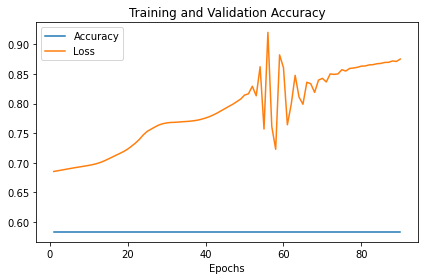

In [62]:
import matplotlib.pyplot as plt

epochs = range(1, len(loss_val) + 1)
plt.plot(epochs, acc_val, label='Accuracy')
plt.plot(epochs, loss_val, label='Loss')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.tight_layout()
plt.show()